# 02 - Traitement des Données

## Objectif
Préparer les données pour la modélisation en appliquant les techniques de prétraitement appropriées :
- Nettoyage des valeurs manquantes
- Gestion des valeurs aberrantes
- Feature engineering
- Encodage des variables catégorielles
- Normalisation des variables numériques
- Séparation train/validation/test

## Plan d'Action
1. Chargement et validation des données
2. Nettoyage des données
3. Feature engineering
4. Prétraitement avec pipeline sklearn
5. Séparation des données
6. Sauvegarde des données traitées

In [12]:
# Importations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import joblib
import warnings
from datetime import datetime

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.3f}'.format)

In [13]:
# Chargement du dataset
df = pd.read_csv('../data/raw/online_sales_dataset_cleaned.csv')

print(f"Données chargées: {df.shape}")
print(f"Colonnes: {list(df.columns)}")
print("\nAperçu des données:")
display(df.head())

print("\nInformations générales:")
display(df.info())

print("\nValeurs manquantes:")
missing_values = df.isnull().sum()
missing_pct = (missing_values / len(df) * 100).round(2)
missing_summary = pd.DataFrame({
    'Valeurs manquantes': missing_values,
    'Pourcentage (%)': missing_pct
})
display(missing_summary[missing_summary['Valeurs manquantes'] > 0])

Données chargées: (49782, 6)
Colonnes: ['Quantity', 'UnitPrice', 'Discount', 'ShippingCost', 'Category', 'ReturnStatus']

Aperçu des données:


,Quantity,UnitPrice,Discount,ShippingCost,Category,ReturnStatus
0,38,1.710,0.470,10.790,Apparel,Not Returned
1,18,41.250,0.190,9.510,Electronics,Not Returned
2,49,29.110,0.350,23.030,Electronics,Returned
3,14,76.680,0.140,11.080,Accessories,Not Returned
4,-30,-68.110,1.501,NaN,Electronics,Not Returned



Informations générales:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49782 entries, 0 to 49781
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Quantity      49782 non-null  int64  
 1   UnitPrice     49782 non-null  float64
 2   Discount      49782 non-null  float64
 3   ShippingCost  47293 non-null  float64
 4   Category      49782 non-null  object 
 5   ReturnStatus  49782 non-null  object 
dtypes: float64(3), int64(1), object(2)
memory usage: 2.3+ MB


None


Valeurs manquantes:


,Valeurs manquantes,Pourcentage (%)
ShippingCost,2489,5.000


In [14]:
# 2. Nettoyage des données
# Copie pour préserver l'original
df_clean = df.copy()

# 2.1 Traitement des valeurs manquantes
# ShippingCost: Remplacer par la médiane
median_shipping = df_clean['ShippingCost'].median()
df_clean['ShippingCost'] = df_clean['ShippingCost'].fillna(median_shipping)
print(f"  ShippingCost: médiane = {median_shipping:.3f}")

# 2.2 Gestion des valeurs aberrantes
numeric_cols = ['Quantity', 'UnitPrice', 'Discount', 'ShippingCost']

for col in numeric_cols:
    # Calcul des bornes IQR
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Comptage des outliers
    outliers = df_clean[(df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)]
    print(f"  {col}: {len(outliers)} valeurs aberrantes ({len(outliers)/len(df_clean)*100:.1f}%)")
    
    # Capping (limitation aux bornes)
    df_clean[col] = np.clip(df_clean[col], lower_bound, upper_bound)

print(f"\nDimensions: {df_clean.shape}")

  ShippingCost: médiane = 17.500
  Quantity: 1090 valeurs aberrantes (2.2%)
  UnitPrice: 751 valeurs aberrantes (1.5%)
  Discount: 996 valeurs aberrantes (2.0%)
  ShippingCost: 0 valeurs aberrantes (0.0%)

Dimensions: (49782, 6)


In [15]:
# 3. Feature Engineering
# Prix total
df_clean['TotalPrice'] = df_clean['Quantity'] * df_clean['UnitPrice']

# Promotion
df_clean['DiscountRate'] = np.where(
    df_clean['TotalPrice'] > 0,
    df_clean['Discount'] / df_clean['TotalPrice'],
    0
)
df_clean['DiscountRate'] = df_clean['DiscountRate'].fillna(0)

# Ratio coût de transport / prix total
df_clean['ShippingRatio'] = np.where(
    df_clean['TotalPrice'] > 0,
    df_clean['ShippingCost'] / df_clean['TotalPrice'],
    0
)
df_clean['ShippingRatio'] = df_clean['ShippingRatio'].fillna(0)

# Prix relatif par catégorie
category_price_stats = df_clean.groupby('Category')['UnitPrice'].agg(['mean', 'std']).reset_index()
category_price_stats.columns = ['Category', 'CategoryAvgPrice', 'CategoryStdPrice']
print(f"  Category stats shape: {category_price_stats.shape}")
print(f"  Category stats columns: {list(category_price_stats.columns)}")

df_clean = df_clean.merge(category_price_stats, on='Category', how='left')
print(f"  DataFrame après merge: {df_clean.shape}")
print(f"  Colonnes après merge: {list(df_clean.columns)}")

# Vérification que les colonnes existent bien
if 'CategoryAvgPrice' in df_clean.columns:
    df_clean['PriceVsCategoryAvg'] = df_clean['UnitPrice'] / df_clean['CategoryAvgPrice']
    df_clean['PriceVsCategoryAvg'] = df_clean['PriceVsCategoryAvg'].fillna(1)
else:
    print("ERREUR: 'CategoryAvgPrice' n'existe pas après le merge!")
    print("Colonnes disponibles:", list(df_clean.columns))

business_features = ['TotalPrice', 'DiscountRate', 'ShippingRatio', 'PriceVsCategoryAvg']
print(f"  Features métier créées: {len(business_features)}")

#Encodage de la variable cible
target_mapping = {'Returned': 1, 'Not Returned': 0}
df_clean['ReturnStatus'] = df_clean['ReturnStatus'].map(target_mapping)

print(f"  Distribution cible: {df_clean['ReturnStatus'].value_counts().to_dict()}")
print(f"  Taux de retour: {df_clean['ReturnStatus'].mean():.3f}")

print(f"\nFeature engineering terminé. Dimensions: {df_clean.shape}")
print(f"Nouvelles colonnes: {len(df_clean.columns) - len(df.columns)}")

  Category stats shape: (5, 3)
  Category stats columns: ['Category', 'CategoryAvgPrice', 'CategoryStdPrice']
  DataFrame après merge: (49782, 11)
  Colonnes après merge: ['Quantity', 'UnitPrice', 'Discount', 'ShippingCost', 'Category', 'ReturnStatus', 'TotalPrice', 'DiscountRate', 'ShippingRatio', 'CategoryAvgPrice', 'CategoryStdPrice']
  Features métier créées: 4
  Distribution cible: {0: 44888, 1: 4894}
  Taux de retour: 0.098

Feature engineering terminé. Dimensions: (49782, 12)
Nouvelles colonnes: 6


In [16]:
# 4. Préparation pour le prétraitement
# Colonnes à exclure (ID, descriptions, dates originales)
exclude_cols = ['InvoiceNo', 'StockCode', 'Description', 'InvoiceDate', 'CustomerID']

# Identification des colonnes catégorielles et numériques
categorical_cols = []
numeric_cols = []

for col in df_clean.columns:
    if col not in exclude_cols and col != 'ReturnStatus':
        if df_clean[col].dtype == 'object':
            categorical_cols.append(col)
        elif df_clean[col].dtype in ['int64', 'float64', 'int32', 'float32']:
            numeric_cols.append(col)

print(f"Colonnes identifiées:")
print(f"  Catégorielles ({len(categorical_cols)}): {categorical_cols}")
print(f"  Numériques ({len(numeric_cols)}): {numeric_cols}")
print(f"  Target: ReturnStatus")

# Séparation features/target
X = df_clean[categorical_cols + numeric_cols]
y = df_clean['ReturnStatus']

print(f"\nDimensions finales:")
print(f"  Features: {X.shape}")
print(f"  Target: {y.shape}")

Colonnes identifiées:
  Catégorielles (1): ['Category']
  Numériques (10): ['Quantity', 'UnitPrice', 'Discount', 'ShippingCost', 'TotalPrice', 'DiscountRate', 'ShippingRatio', 'CategoryAvgPrice', 'CategoryStdPrice', 'PriceVsCategoryAvg']
  Target: ReturnStatus

Dimensions finales:
  Features: (49782, 11)
  Target: (49782,)


In [17]:
# 5. Pipeline de prétraitement sklearn
# Pipeline pour les variables catégorielles
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

# Pipeline pour les variables numériques
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Préprocesseur combiné
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols),
        ('num', numeric_transformer, numeric_cols)
    ],
    remainder='drop'
)

print(f"Transformateur catégoriel: {len(categorical_cols)} colonnes")
print(f"Transformateur numérique: {len(numeric_cols)} colonnes")

Transformateur catégoriel: 1 colonnes
Transformateur numérique: 10 colonnes


In [18]:
# 6. Séparation train/validation/test
# Séparation stratifiée: 70% train, 15% validation, 15% test
# Première séparation: train vs temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, 
    test_size=0.30, 
    random_state=42, 
    stratify=y
)

# Deuxième séparation: validation vs test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, 
    test_size=0.50, 
    random_state=42, 
    stratify=y_temp
)

print(f"\nRépartition des données:")
print(f"  Train: {X_train.shape} ({len(X_train)/len(X)*100:.1f}%)")
print(f"  Validation: {X_val.shape} ({len(X_val)/len(X)*100:.1f}%)")
print(f"  Test: {X_test.shape} ({len(X_test)/len(X)*100:.1f}%)")

print(f"\nDistribution de la cible:")
print(f"  Train: {y_train.mean():.3f}")
print(f"  Validation: {y_val.mean():.3f}")
print(f"  Test: {y_test.mean():.3f}")


Répartition des données:
  Train: (34847, 11) (70.0%)
  Validation: (7467, 11) (15.0%)
  Test: (7468, 11) (15.0%)

Distribution de la cible:
  Train: 0.098
  Validation: 0.098
  Test: 0.098


In [19]:
# 7. Application du pipeline de prétraitement
# Fit et transform sur les données d'entraînement
X_train_processed = preprocessor.fit_transform(X_train)

# Transform sur validation et test
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

# Récupération des noms de features après transformation
feature_names = preprocessor.get_feature_names_out()

# Conversion en DataFrames
X_train_df = pd.DataFrame(X_train_processed, columns=feature_names)
X_val_df = pd.DataFrame(X_val_processed, columns=feature_names)
X_test_df = pd.DataFrame(X_test_processed, columns=feature_names)

print(f"  Features finales: {len(feature_names)}")
print(f"  Train: {X_train_df.shape}")
print(f"  Validation: {X_val_df.shape}")
print(f"  Test: {X_test_df.shape}")

# Vérification des valeurs manquantes
print(f"\nVérification des valeurs manquantes:")
print(f"  Train: {X_train_df.isnull().sum().sum()}")
print(f"  Validation: {X_val_df.isnull().sum().sum()}")
print(f"  Test: {X_test_df.isnull().sum().sum()}")

  Features finales: 14
  Train: (34847, 14)
  Validation: (7467, 14)
  Test: (7468, 14)

Vérification des valeurs manquantes:
  Train: 0
  Validation: 0
  Test: 0


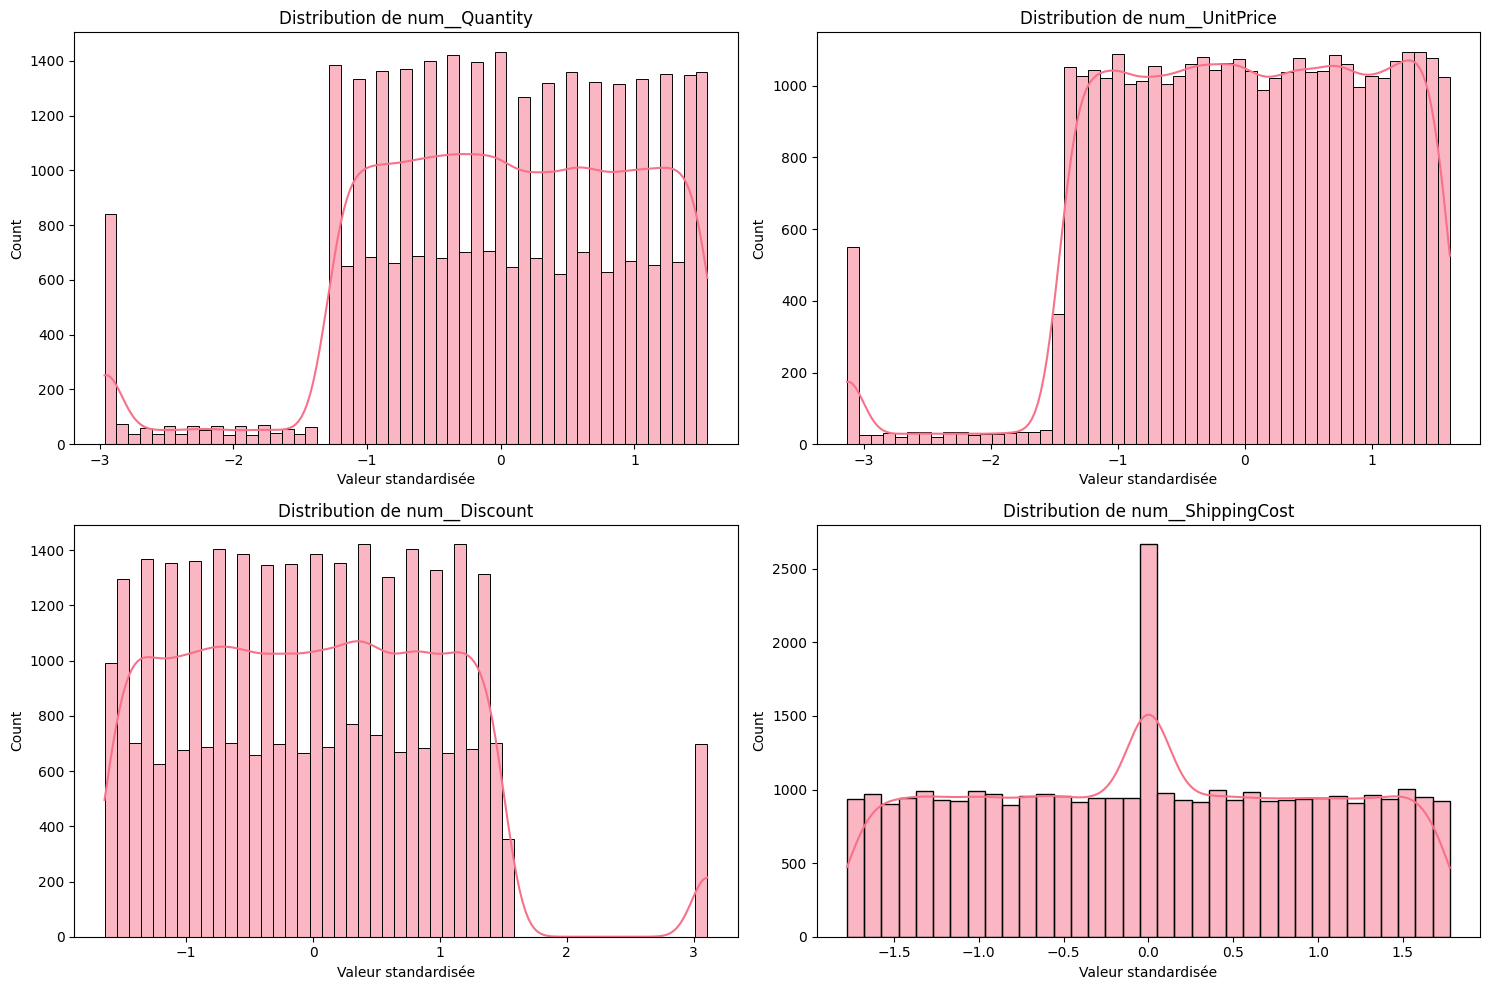

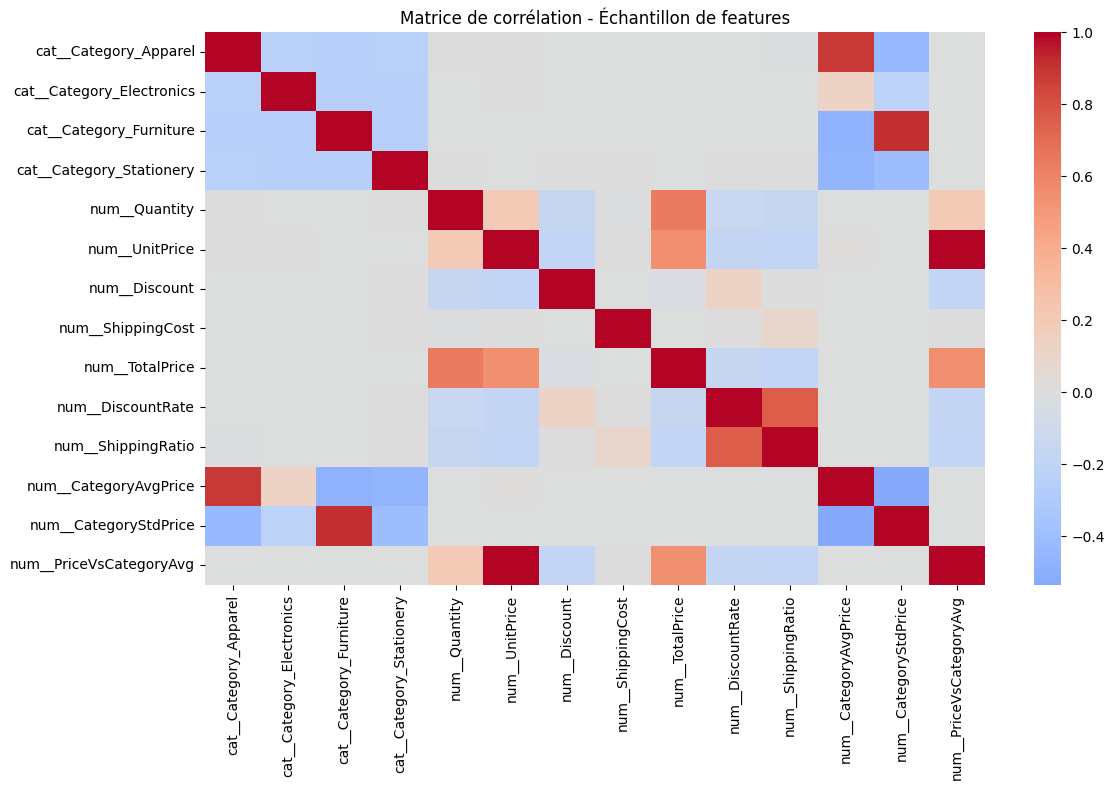

In [20]:
# 8. Visualisation des données prétraitées
# Distribution des features numériques après standardisation
numeric_features = [col for col in feature_names if any(num_col in col for num_col in numeric_cols)]

if len(numeric_features) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.ravel()
    
    for i, feature in enumerate(numeric_features[:4]):  # Premières 4 features numériques
        if i < 4:
            sns.histplot(X_train_df[feature], kde=True, ax=axes[i])
            axes[i].set_title(f'Distribution de {feature}')
            axes[i].set_xlabel('Valeur standardisée')
    
    # Masquer les subplots vides
    for i in range(len(numeric_features), 4):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# Matrice de corrélation pour un échantillon de features
sample_features = feature_names[:20]  # Premières 20 features
correlation_matrix = X_train_df[sample_features].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Matrice de corrélation - Échantillon de features')
plt.tight_layout()
plt.show()

In [21]:
# 9. Sauvegarde des données prétraitées
# Préparation du dictionnaire de données
processed_data = {
    # Données prétraitées
    'X_train': X_train_df,
    'X_val': X_val_df,
    'X_test': X_test_df,
    'y_train': y_train,
    'y_val': y_val,
    'y_test': y_test,
    
    # Métadonnées
    'feature_names': feature_names.tolist(),
    'categorical_features': categorical_cols,
    'numeric_features': numeric_cols,
    'preprocessor': preprocessor,
    
    # Informations sur le traitement
    'processing_info': {
        'original_shape': df.shape,
        'processed_shape': X_train_df.shape,
        'total_samples': len(X_train_df) + len(X_val_df) + len(X_test_df),
        'train_samples': len(X_train_df),
        'val_samples': len(X_val_df),
        'test_samples': len(X_test_df),
        'n_features': len(feature_names),
        'target_distribution': {
            'train_rate': float(y_train.mean()),
            'val_rate': float(y_val.mean()),
            'test_rate': float(y_test.mean())
        },
        'processing_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    }
}

# Sauvegarde
output_path = '../data/processed/preprocessed_data.pkl'
joblib.dump(processed_data, output_path)

['../data/processed/preprocessed_data.pkl']